In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RL

import numpy as np
import MDP
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/RL'
/content/drive/MyDrive/RL


# RL2

In [ ]:
class RL2:
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleSoftmaxPolicy(self, policyParams, state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        
        p = policyParams[:, state]
        softmax = np.exp(p)/ np.sum(np.exp(p))
        action = np.random.choice(np.arange(0, self.mdp.nActions), p=softmax)

        return action

    def modelBasedRL(self,s0,defaultT,initialR,nEpisodes,nSteps,epsilon=0):
        '''Model-based Reinforcement Learning with epsilon greedy 
        exploration.  This function should use value iteration,
        policy iteration or modified policy iteration to update the policy at each step

        Inputs:
        s0 -- initial state
        defaultT -- default transition function when a state-action pair has not been vsited
        initialR -- initial estimate of the reward function
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random

        Outputs: 
        V -- final value function
        policy -- final policy
        '''

        # Counters
        stateActionSeenCount = np.zeros((self.mdp.nActions, self.mdp.nStates))
        stateActionStateSeenCount = np.zeros((self.mdp.nActions, self.mdp.nStates, self.mdp.nStates))
        
        # Transition and reward model
        stateChangeProbabilty = np.zeros((self.mdp.nActions, self.mdp.nStates, self.mdp.nStates))
        stateChangeProbabilty = defaultT
        reward = np.zeros((self.mdp.nActions, self.mdp.nStates))
        reward = initialR

        # Policy and value function
        V = np.zeros(self.mdp.nStates)
        policy = np.zeros(self.mdp.nStates,int)

        # Our model of the system
        model = MDP.MDP(stateChangeProbabilty, reward, self.mdp.discount)

        # Trace the cumulative discounted reward
        cumulative_discounted_reward_trace = np.zeros(nEpisodes)

        for episodeIter in range(nEpisodes):
            state = s0

            for stepIter in range(nSteps):
                # Action Selection
                if np.random.rand() < epsilon:
                    action = np.random.randint(0, self.mdp.nActions)
                else:
                    action = policy[state]

                # Take action
                r, nextState = self.sampleRewardAndNextState(state, action)
                cumulative_discounted_reward_trace[episodeIter] += r * np.power(self.mdp.discount, stepIter)

                # Update counters
                stateActionSeenCount[action, state] += 1
                stateActionStateSeenCount[action, state, nextState] += 1

                # Update transition
                stateChangeProbabilty[action, state] = stateActionStateSeenCount[action, state] / stateActionSeenCount[action, state]

                # Update reward
                reward[action, state] = (r + (stateActionSeenCount[action, state] - 1) * reward[action, state]) / stateActionSeenCount[action, state]

                # Find the new value fcn
                model.T = stateChangeProbabilty
                model.R = reward
                V, _, _ = model.valueIteration(V)
                state = nextState
                policy = model.extractPolicy(V)
        
        return V, policy, cumulative_discounted_reward_trace

    def epsilonGreedyBandit(self,nIterations):
        '''Epsilon greedy algorithm for bandits (assume no discount factor).  Use epsilon = 1 / # of iterations.

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        empiricalMeans = np.zeros(self.mdp.nActions)
        attempts = np.zeros(self.mdp.nActions)
        state = 0
        reward_trace = np.zeros(nEpisodes)

        for iterId in range(1, nIterations + 1):
            
            # Action selection
            epsilon = 1 / iterId
            randTmp = np.random.rand()
            if randTmp < epsilon:
                actionList = np.arange(0, self.mdp.nActions)
                action = np.random.choice(actionList)
            else:
                action = np.argmax(empiricalMeans)

            # Act and take the reward
            reward, nextState = self.sampleRewardAndNextState(state, action)
            state = nextState
            reward_trace[iterId-1] = reward

            # Update the empiricalMeans
            prevSum = empiricalMeans[action] * attempts[action]
            attempts[action] += 1
            empiricalMeans[action] = (prevSum + reward) / attempts[action]

        return empiricalMeans, reward_trace

    def thompsonSamplingBandit(self,prior,nIterations,k=1):
        '''Thompson sampling algorithm for Bernoulli bandits (assume no discount factor)
        
        Inputs:
        prior -- initial beta distribution over the average reward of each arm (|A|x2 matrix such that prior[a,0] is the alpha hyperparameter for arm a and prior[a,1] is the beta hyperparameter for arm a)  
        nIterations -- # of arms that are pulled
        k -- # of sampled average rewards

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        state = 0
        empiricalMeans = np.zeros(self.mdp.nActions)
        reward_trace = np.zeros(nEpisodes)

        for iterId in range(nIterations):
            # Sample theta regarding each action
            theta_vector = np.zeros((self.mdp.nActions, k))
            for iter, item in enumerate(prior):
                theta_vector[iter, :] = np.random.beta(item[0], item[1], size=k)
            
            # Take average
            empiricalMeans = np.mean(theta_vector, axis=1)
            action = np.argmax(empiricalMeans)

            # Execute
            reward, nextState = self.sampleRewardAndNextState(state, action)
            nextState = state
            reward_trace[iterId] = reward

            # Uppdate Beta distribution
            if reward == 1:
                prior[action, 0] += 1
            else:
                prior[action, 1] += 1

        return empiricalMeans, reward_trace

    def UCBbandit(self,nIterations):
        '''Upper confidence bound algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        empiricalMeans = np.ones(self.mdp.nActions) * np.inf
        attempts = np.zeros(self.mdp.nActions)
        state = 0
        reward_trace = np.zeros(nEpisodes)

        for iterId in range(1, nIterations + 1):
            
            # Action Selection
            p = np.where(empiricalMeans == np.inf, empiricalMeans, empiricalMeans + np.sqrt(2*np.log(iterId)/attempts))
            action = np.argmax(p)

            # Act and take the reward
            [reward, nextState] = self.sampleRewardAndNextState(state, action)
            state = nextState
            reward_trace[iterId-1] = reward

            # Update the empiricalMeans
            if empiricalMeans[action] == np.inf:
                attempts[action] = 1
                empiricalMeans[action] = reward / attempts[action]
            else:
                prevSum = empiricalMeans[action] * attempts[action]
                attempts[action] += 1
                empiricalMeans[action] = (prevSum + reward) / attempts[action]

        return empiricalMeans, reward_trace

    def reinforce(self,s0,initialPolicyParams,nEpisodes,nSteps,alpha=0.01):
        '''reinforce algorithm.  Learn a stochastic policy of the form
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))]).
        This function should call the function sampleSoftmaxPolicy(policyParams,state) to select actions

        Inputs:
        s0 -- initial state
        initialPolicyParams -- parameters of the initial policy (array of |A|x|S| entries)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0)
        nSteps -- # of steps per episode

        Outputs: 
        policyParams -- parameters of the final policy (array of |A|x|S| entries)
        '''

        policyParams = np.zeros((self.mdp.nActions,self.mdp.nStates))
        policyParams = initialPolicyParams
        cumulative_discounted_reward_trace = np.zeros(nEpisodes)

        for episodeIter in range(nEpisodes):
            state = s0
            # Generate Episodes
            episodeTrace = np.zeros((nSteps, 3))
            for stepIter in range(nSteps):
                action = self.sampleSoftmaxPolicy(policyParams, state)
                reward, nextState = self.sampleRewardAndNextState(state, action)
                episodeTrace[stepIter] = [state, action, reward]
                state = nextState
                cumulative_discounted_reward_trace[episodeIter] += reward * np.power(self.mdp.discount, stepIter)

            # Gradient policy 
            for stepIter in range(nSteps):
                G = 0 
                for t in range(0, nSteps-stepIter):
                    G += (self.mdp.discount ** t) * episodeTrace[stepIter+t, 2]
                gradient = - np.exp(policyParams[:, int(episodeTrace[stepIter, 0])])
                gradient /= np.sum(np.exp(policyParams[:, int(episodeTrace[stepIter, 0])]))
                gradient[int(episodeTrace[stepIter, 1])] += 1 
                policyParams[:, int(episodeTrace[stepIter, 0])] += alpha * (self.mdp.discount ** stepIter) * G * gradient

        return policyParams, cumulative_discounted_reward_trace
    
    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=0):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with
        probabilty epsilon and performing Boltzmann exploration otherwise.
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs:
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        temperature = float(temperature)
        counts = np.zeros([self.mdp.nActions, self.mdp.nStates])
        Q = np.copy(initialQ)
        ep_rewards = []

        for episode in range(nEpisodes):
            s = np.copy(s0)
            discounted_rewards = 0.
            for step in range(nSteps):
                if np.random.uniform() < epsilon:
                    a = np.random.randint(self.mdp.nActions)
                else:
                    if temperature == 0.:
                        a = np.argmax(Q[:, s])
                    else:
                        prob_a = np.exp(Q[:, s] / temperature) / np.sum(np.exp(Q[:, s] / temperature))
                        a = np.argmax(np.random.multinomial(1, prob_a))

                r, next_s = self.sampleRewardAndNextState(s, a)
                discounted_rewards += self.mdp.discount**step * r

                counts[a, s] += 1.
                Q[a, s] += (1. / counts[a, s]) * (r + self.mdp.discount * np.amax(Q[:, next_s]) - Q[a, s])
                s = np.copy(next_s)
            ep_rewards.append(discounted_rewards)

        policy = np.argmax(Q, axis=0)

        return [Q,policy,np.array(ep_rewards)]

# RL Problem Defenition

In [ ]:
''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP.MDP(T,R,discount)

# RL problem
rlProblem = RL2(mdp,np.random.normal)

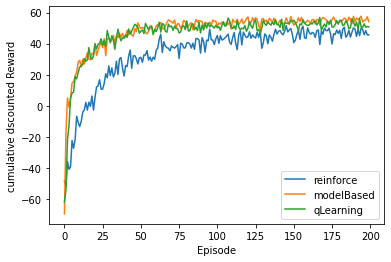

In [ ]:
# Experiment Parameters
nEpisodes = 200
nTrials = 100
nSteps = 100
alpha = 0.01
epsilon = 0.05

# Initialization
qlearning_trace = np.zeros((nTrials, nEpisodes))
model_based_cdr_trace = np.zeros((nTrials, nEpisodes))
reinforce_cdr_trace = np.zeros((nTrials, nEpisodes))

# Do the trisals!
for trialIter in range(nTrials):
    _, cumulative_discounted_reward_trace = rlProblem.reinforce(s0=0,initialPolicyParams=np.random.rand(mdp.nActions,mdp.nStates),nEpisodes=nEpisodes,nSteps=nSteps)
    reinforce_cdr_trace[trialIter] = cumulative_discounted_reward_trace

    V, policy, cumulative_discounted_reward_trace = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=nEpisodes,nSteps=nSteps,epsilon=epsilon)
    model_based_cdr_trace[trialIter] = cumulative_discounted_reward_trace

    _, _, cumulative_discounted_reward_trace = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=nEpisodes,nSteps=nSteps,epsilon=epsilon)
    qlearning_trace[trialIter] = cumulative_discounted_reward_trace

# Take average of the trials
reinforce_graph = np.mean(reinforce_cdr_trace, axis=0)
model_based_graph = np.mean(model_based_cdr_trace, axis=0)
qlearning_graph = np.mean(qlearning_trace, axis=0)

# Plot
plt.plot(reinforce_graph, label="reinforce")
plt.plot(model_based_graph, label="modelBased")
plt.plot(qlearning_graph, label="qLearning")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("cumulative dscounted Reward")
plt.show()

## Explanation:
**Explain the results. Discuss how different properties of each algorithm influence the cumulative discounted rewards per episode earned during training as well as the resulting Q-values and policy.**


It's clear that reinforce method performs poorly compared to the other two methods. One reason for this could be the fact that the epsilon for the other 2 metohds is rather high and constant to the end, so they explore more than reinforce; Reinforce only uses softmax. As another reason, we sould note that in reinforce method, we first generate the whole episode with the same policy, and after that we update the policy, so we skip using the new inforamtion obtained during that episode until the next episode. This practice prevents us from better selecting some actions during that generated episode by postponing the update policy.

Besides, figure shows that model-based approach and q-learning are performing equally well and there's no meaningful difference between them. It makes sense since in both methods we are selecting action with the same strategy of epsilon-greedy, and both of them are value-based (I cholse value iteration here).

# Bandit Problem Defenition

In [ ]:
def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli
    
    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean: return 1
    else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999
mdp = MDP.MDP(T,R,discount)
banditProblem = RL2(mdp,sampleBernoulli)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning: divide by zero encountered in true_divide


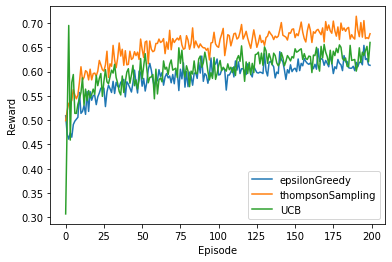

In [ ]:
# Experiment Parameters
nIterations = 200
nTrials = 1000

# Initialization
epsilonGreedy_trace = np.zeros((nTrials, nIterations))
thompsonSampling_trace = np.zeros((nTrials, nIterations))
UCB_trace = np.zeros((nTrials, nIterations))

# Do the trisals!
for trialIter in range(nTrials):
    x, reward_trace = banditProblem.epsilonGreedyBandit(nIterations=nIterations)
    epsilonGreedy_trace[trialIter] = reward_trace

    x, reward_trace = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=nIterations)
    thompsonSampling_trace[trialIter] = reward_trace

    x, reward_trace = banditProblem.UCBbandit(nIterations=200)
    UCB_trace[trialIter] = reward_trace

# Take average of the trials
epsilonGreedy_graph = np.mean(epsilonGreedy_trace, axis=0)
thompsonSampling_graph = np.mean(thompsonSampling_trace, axis=0)
UCB_graph = np.mean(UCB_trace, axis=0)
    
# Plot
plt.plot(epsilonGreedy_graph, label="epsilonGreedy")
plt.plot(thompsonSampling_graph, label="thompsonSampling")
plt.plot(UCB_graph, label="UCB")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

### Explanation:
***Explain the results. Are the results surprising? Do they match what is expected based on the theory?***

First of all, it's clear that Thompson sampling performs the best. That is because the other two methods are greedy (UCB tends to prefer the action that found to be better and epsilon greedy method stops exploration rather early by shrinking epsilon), however, with k=1, Thomspon sampling embraces exploration at any time. Therefore, it has reached higher rewards that the other methods were not able to. This is aligned with what we expected in theory since with more exploration we won't get stuck in a local optima. 
Secondly, we expected that UCB and epsilon greedy perfom equally good (logarithmic expected cumulative regret), but one can observe that UCB has slighty gained higher rewards. 